# Bank Account Fraud (NeurIPS 2022)

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Matplotlib to display plots inline in the notebook
%matplotlib inline

In [ ]:
# Increase the maximum number of columns displayed in Pandas to 200
pd.set_option('display.max_columns', 200)

# Set the default style of Matplotlib plots to "ggplot"
plt.style.use('ggplot')

In [ ]:
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv("Base.csv")

In [ ]:
# Create a deep copy of the DataFrame
new_df = df.copy()

## Exploratory Data Analysis of Bank Account Applications

In [ ]:
# Get the number of rows and columns in the DataFrame
df_shape = df.shape
print("Number of rows:", df_shape[0])
print("Number of columns:", df_shape[1])

In [ ]:
# Display the first 5 rows of the DataFrame
df.head()

In [ ]:
# Display summary information about the DataFrame
df.info()

In [ ]:
# Get the number of unique values in each column of the DataFrame
df.nunique()

In [ ]:
# Get a summary of statistical information for each numerical column in the DataFrame
df.describe().transpose()

In [ ]:
# Get a summary of statistical information for each non-numerical column in the DataFrame
df.describe(include=["object", "bool"]).transpose()

### 1. Number of Transactions by Fraud Status

In [ ]:
# Create a new DataFrame showing the count of unique values in the 'fraud_bool' column
fraud_vals = pd.DataFrame(df['fraud_bool'].value_counts())
print(fraud_vals)

In [ ]:
# Reset the index of the DataFrame and rename the columns
fraud_vals.reset_index(inplace=True)
fraud_vals.rename(columns={'index': 'fraud_bool', 'fraud_bool': 'count'}, inplace=True)
print(fraud_vals)

In [ ]:
# Define custom color palette
my_palette = sns.color_palette("husl", 2)
sns.set_style("whitegrid")

In [ ]:
# Set up plot
plt.figure(figsize=(8, 6))

# Create bar plot
sns.barplot(data=fraud_vals, x="fraud_bool", y="count", palette=my_palette, alpha=.6)

# Customize labels and legend
plt.xlabel("Fraud", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Number of Transactions by Fraud Status", fontsize=14)

# Display plot
plt.show()

### 2. Missing Values of Features by Fraud Status

In [ ]:
# Initialize an empty DataFrame to hold the percentage of missing values for each feature
missing_vals = pd.DataFrame()

# List of features to check for missing values
missing_features = ['prev_address_months_count', 'current_address_months_count', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']

# For each feature, replace -1 values with NaN, calculate the percentage of missing values, and add to the missing_vals DataFrame
for feature in missing_features:
    df[feature] = df[feature].replace(-1, np.nan)
    missing_vals_col = df.groupby('fraud_bool')[feature].apply(lambda x: round(x.isna().sum()/len(x) * 100, 2))
    missing_vals[feature] = missing_vals_col

print(missing_vals)

In [ ]:
# Reshape the missing_vals DataFrame from wide to long format
missing_vals = pd.DataFrame(missing_vals.T.stack())

# Reset the index and rename the columns
missing_vals.reset_index(inplace=True)
missing_vals.rename(columns={'level_0': 'feature', 0: 'missing_vals'}, inplace=True)

print(missing_vals)

In [ ]:
# Set up plot
plt.figure(figsize=(8, 6))

# Create bar plot
sns.catplot(data=missing_vals, kind="bar", x="feature", y="missing_vals", hue="fraud_bool", palette=my_palette, alpha=.6, height=4, aspect=2, legend=False)

# Customize labels and legend
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Missing Values", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.title("Missing Values of Features by Fraud Status", fontsize=14)
plt.legend(title="Fraud", fontsize=10)

# Display plot
plt.show()

### 3. Distribution and Outliers of Features by Fraud Status

In [ ]:
# Create a list of numeric features in the DataFrame df
numeric_features = [x for x in df.columns if df[x].nunique() >= 10]

print(numeric_features)

In [ ]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))

# Add a title to the figure
fig.suptitle('Distribution of Numeric Features by Fraud Status')

# Loop through the numeric features and plot a kernel density plot for each feature
for i, feature in enumerate(numeric_features):
    ax = axes[i // 3][i % 3]
    sns.kdeplot(data=df[df['fraud_bool'] == 0][feature], fill=True, ax=ax, label='Not Fraud')
    sns.kdeplot(data=df[df['fraud_bool'] == 1][feature], fill=True, ax=ax, label='Fraud')
    ax.set_xlabel(feature)
    ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))

# Add a title to the figure
fig.suptitle('Box Plot of Numeric Features by Fraud Status')

# Loop through the numeric features and plot a box plot for each feature
for i, feature in enumerate(numeric_features):
    ax = axes[i // 3][i % 3]
    sns.boxplot(data=df, x='fraud_bool', y=feature, ax=ax, palette=my_palette, boxprops=dict(alpha=.6))
    ax.set_xlabel('')
    ax.set_ylabel(feature)
    ax.set_xticklabels(['Not Fraud', 'Fraud'])

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

## Feature Engineering for Fraud Detection of Bank Account Applications

### 1. One-Hot Encoding for Categorical Features

In [ ]:
# Create a list of categorical features in the DataFrame new_df whose data type is `object`
categorical_features = [x for x in new_df.columns if new_df[x].dtypes == "O"]

print(categorical_features)

In [ ]:
# Convert categorical variables into dummy variables using one-hot encoding
new_df = pd.DataFrame(pd.get_dummies(new_df, prefix=categorical_features))

In [ ]:
# Display the first 5 rows of the DataFrame
new_df.head()

In [ ]:
# Separate the feature matrix and target variable
X = new_df.drop(['fraud_bool'], axis=1)
y = new_df['fraud_bool']

In [ ]:
# Import the necessary library for splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

In [ ]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

### 2. Min-Max Scaling for Numerical Features

In [ ]:
# Import the necessary libraries for data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Scale the numeric features in the training and testing sets using MinMaxScaler
numeric_transformer = MinMaxScaler()

# Define the ColumnTransformer object with the numeric transformer and the list of numeric features
preprocessor = ColumnTransformer([('scaled', numeric_transformer, numeric_features)], remainder='passthrough')

# Fit the preprocessor on the training set and transform both the training and testing sets
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [ ]:
# Get the names of the features after pre-processing
feature_names = preprocessor.get_feature_names_out()

# Remove 'remainder__' from the feature names
feature_names = [feature.replace('remainder__', '') for feature in feature_names]

# Print the pre-processed feature names
print(feature_names)

In [ ]:
# Convert the scaled training and testing sets to pandas DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

## Feature Selection for Fraud Detection of Bank Account Applications

In [ ]:
# Import the necessary libraries for feature selection
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, chi2, mutual_info_classif
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import ExtraTreesClassifier

### Resampling for Effective Feature Selection Tests

In [ ]:
# Import the necessary libraries for undersampling imbalanced datasets
from imblearn.under_sampling import NearMiss
from collections import Counter

In [ ]:
%%time

# Perform NearMiss undersampling to handle imbalanced data
print(f'Test dataset samples per class {Counter(y_train)}')

# Define the NearMiss undersampling object with a sampling strategy of 1 and all available CPU cores
nm = NearMiss(sampling_strategy=1, n_jobs=-1)

# Perform NearMiss undersampling on the feature matrix X and target variable y
X_train_nm, y_train_nm = nm.fit_resample(X_train_scaled, y_train)

# Print the number of occurrences of each class in the resampled dataset
print('Resampled dataset shape %s' % Counter(y_train_nm))

In [ ]:
# Create a list of categorical features in the DataFrame X_train_nm
categorical_features = [feature for feature in X_train_nm.columns if X_train_nm[feature].nunique() >= 2 and X_train_nm[feature].nunique() < 10]

print(categorical_features)

In [ ]:
# Create a list of numerical features in the DataFrame X_train_nm
numeric_features = [feature for feature in X_train_nm.columns if X_train_nm[feature].nunique() >= 10]

print(numeric_features)

### 1. Variance Threshold Test for Constant Features

In [ ]:
# Instantiate a VarianceThreshold selector and fit it to the NearMiss-resampled training set
selector = VarianceThreshold()
selector.fit(X_train_nm)

# Get the names of the constant features
constant_features = [feature for feature in X_train_nm.columns 
                     if feature not in X_train_nm.columns[selector.get_support()]]

# Print the names of the constant features
print(constant_features)

In [ ]:
# Dropping constant features
X_train_nm.drop(['device_fraud_count'], axis=1, inplace=True)

### 2. Pearson Correlation Test for Multicollinearity

In [ ]:
# Compute correlation matrix
X_train_corr = X_train_nm[numeric_features].corr()

# Plot correlation matrix with annotated values
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(X_train_corr[(X_train_corr >= 0.4) | (X_train_corr <= -0.4)], annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, square=True, ax=ax, annot_kws={"fontsize": 8})
plt.title('Correlation Heatmap')
plt.show()

### 3. Chi-Squared Test for Categorical Features

In [ ]:
# Check the distribution of values in a column
X_train_nm.device_distinct_emails_8w.value_counts()

In [ ]:
# Identify the rows to drop based on a condition on a specific feature
rows_to_drop = np.where(X_train_nm['device_distinct_emails_8w'] < 0)[0]
rows_to_drop

# Drop the corresponding rows in X_train and y_train
X_train_cat = X_train_nm[categorical_features].copy()
X_train_cat.drop(rows_to_drop, axis=0, inplace=True)

y_train_cat = y_train_nm.copy()
y_train_cat.drop(rows_to_drop, axis=0, inplace=True)

In [ ]:
# Use chi-squared test to evaluate the relationship between categorical features and the target variable
chi2_results = chi2(X_train_cat, y_train_cat)

In [ ]:
# Create a pandas DataFrame to store the chi-squared test results
chi2_results_df = pd.DataFrame(data={'feature': X_train_cat.columns, 'chi2': chi2_results[0], 'p_value': chi2_results[1]})

In [ ]:
# Set up plot
plt.figure(figsize=(16, 8))

# Create bar plot
sns.barplot(data=chi2_results_df.sort_values(by='chi2', ascending=False), x="feature", y="chi2", palette=my_palette, alpha=.6)

# Customize labels and legend
plt.xlabel("Features", fontsize=12)
plt.ylabel("chi2", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=5)
plt.title("Chi-Squared Value by Categorical Feature", fontsize=14)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Use SelectKBest with chi-squared test to select the top 5 categorical features that are most strongly associated with the target variable
best_chi2_cols = SelectKBest(chi2, k=15)
best_chi2_cols.fit(X_train_cat, y_train_cat)

# Get the names of the top 5 features
best_chi2_features = [X_train_cat.columns[best_chi2_cols.get_support()]]

# Print the names of the top 5 features
print(best_chi2_features)

### 4. Mutual Information Test for Numerical Features

In [ ]:
# Create a new DataFrame with only the numeric features from the preprocessed training data
X_train_num = X_train_nm[numeric_features].copy()

# Create a copy of the target variable
y_train_num = y_train_nm.copy()

In [ ]:
# Use mutual information test to evaluate the relationship between numerical features and the target variable
mutual_info_results = mutual_info_classif(X_train_num, y_train_num)

In [ ]:
# Create a pandas DataFrame to store the mutual information test results
mutual_info_results_df = pd.DataFrame(data={'feature': X_train_num.columns, 'mutual_info': mutual_info_results})

In [ ]:
# Set up plot
plt.figure(figsize=(16, 8))

# Create bar plot
sns.barplot(data=mutual_info_results_df.sort_values(by='mutual_info', ascending=False), x="feature", y="mutual_info", palette=my_palette, alpha=.6)

# Customize labels and legend
plt.xlabel("Features", fontsize=12)
plt.ylabel("mutual_info", fontsize=12)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title("Mutual Information Value by Numerical Feature", fontsize=14)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Use SelectKBest with mutual information test to select the top 5 numerical features that are most strongly associated with the target variable
best_mutual_info_cols = SelectKBest(mutual_info_classif, k=15)
best_mutual_info_cols.fit(X_train_num, y_train_num)

# Get the names of the top 5 features
best_mutual_info_features = [X_train_num.columns[best_mutual_info_cols.get_support()]]

# Print the names of the top 5 features
print(best_mutual_info_features)

### 5. Extra Trees Classifier for Feature Selection

In [ ]:
extra = ExtraTreesClassifier(n_estimators=50, random_state=0)
extra.fit(X_train_nm, y_train_nm)

# Create a SelectFromModel object with the fitted Random Forest model
feature_sel_extra = SelectFromModel(extra, prefit=True)

# Get the names of the selected features by calling .get_support() on the SelectFromModel object
best_extra_features = [X_train_nm.columns[(feature_sel_extra.get_support())]]
best_extra_features = list(best_extra_features[0])

# Print the names of the selected features
print(best_extra_features)

In [ ]:
extra_importances = pd.DataFrame({'feature': X_train_nm.columns, 'importance': extra.feature_importances_, 'model': 'ExtraTreesClassifier'})

In [ ]:
# Set up plot
plt.figure(figsize=(16, 8))

# Create grouped bar plot
sns.barplot(data=extra_importances.sort_values(by='importance', ascending=False), x="feature", y="importance", hue="model", palette=my_palette, alpha=.6)

# Customize labels and legend
plt.xlabel("Features", fontsize=12)
plt.ylabel("Importance Value", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.title("Feature Importances by Model", fontsize=14)
plt.legend(title='Model', fontsize=12)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Fraud Detection Model Training Functions using SMOTE and Grid Search CV

SMOTE (Synthetic Minority Over-sampling Technique) is an over-sampling technique used to tackle class imbalance problems. Unlike random under-sampling, SMOTE generates synthetic data points to create an equal balance between the minority and majority class. It picks the distance between the closest neighbors of the minority class to create new synthetic points. SMOTE retains more information since no rows are eliminated, unlike random under-sampling. However, SMOTE can take longer to train due to the generation of synthetic data. 

When using SMOTE or undersampling techniques, it is crucial not to apply them before cross-validation. This is because it can influence the validation set before the cross-validation process, leading to overfitting. By doing so, we risk introducing data leakage. Instead, we should generate synthetic data points during cross-validation to avoid affecting the validation set. In this way, synthetic data is created only for the training set, ensuring that the validation set remains untouched.

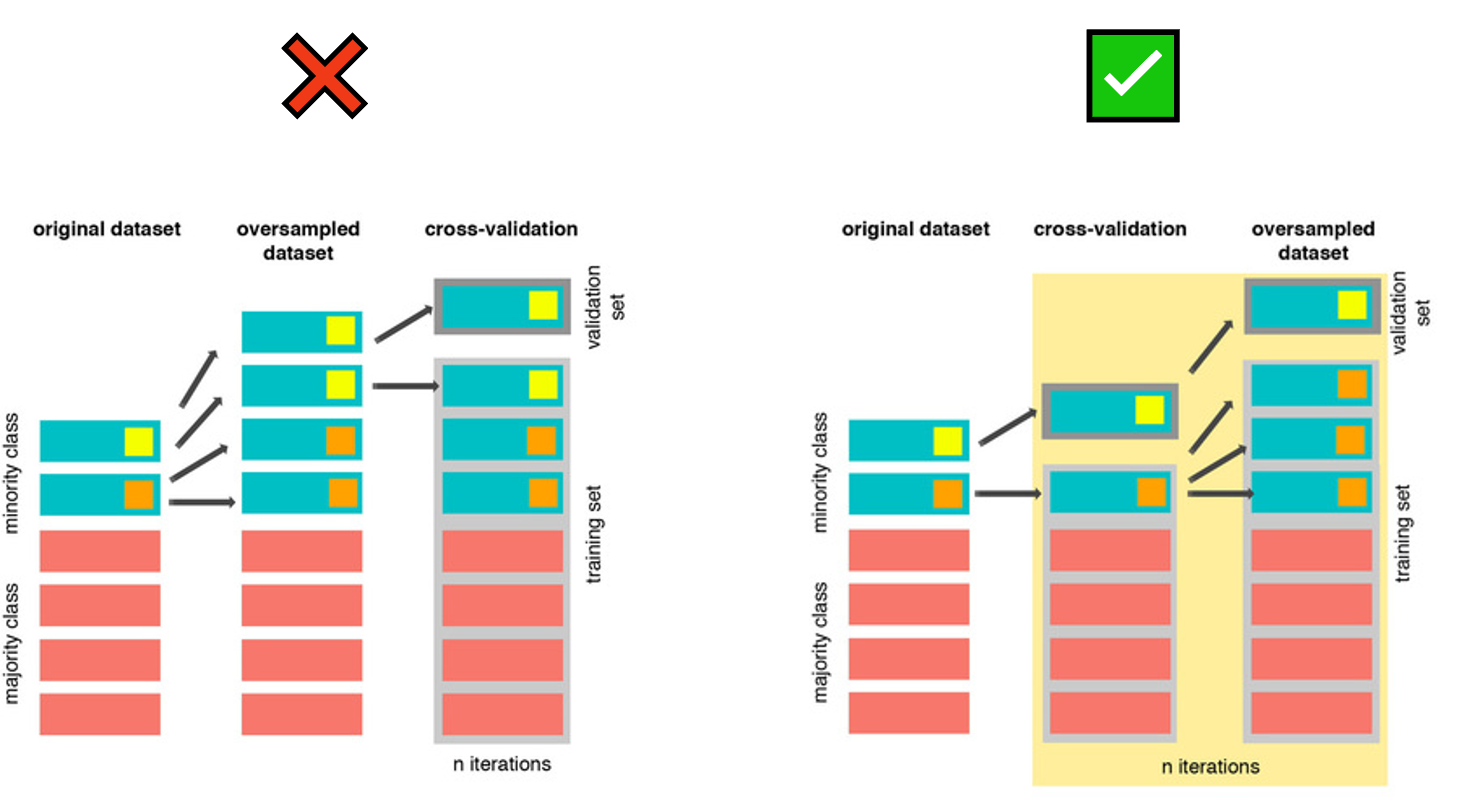

In [ ]:
# Import the necessary libraries for oversampling imbalanced datasets
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import make_pipeline

In [ ]:
# Import necessary modules for hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV

In [ ]:
def train_classifier(classifier, param_dist, X_train, y_train, encoded_features, search_type='random'):
    """
    Train a classifier using the specified parameters and return the trained model.
    
    Parameters:
    classifier (sklearn estimator): The estimator to train.
    param_dist (dict): The distribution of parameters to search over.
    X_train (pandas DataFrame): The training features.
    y_train (pandas Series): The training target.
    encoded_features (list): A list of encoded categorical features.
    search_type (str, optional): The type of hyperparameter search to perform. Must be either 'random' or 'grid'. Defaults to 'random'.
    
    Returns:
    A trained classifier.
    """
    
    # Apply SMOTENC to deal with imbalanced classes
    smote_nc = SMOTENC(categorical_features=encoded_features, sampling_strategy='minority', random_state=42)
        
    # Create pipeline with SMOTENC and the classifier
    pipeline = make_pipeline(smote_nc, classifier)
    
    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Perform hyperparameter search
    if search_type == 'random':
        search_cv = RandomizedSearchCV(estimator=pipeline, 
                                      param_distributions=param_dist,
                                      n_iter=20,
                                      scoring="roc_auc",
                                      n_jobs=-1,
                                      cv=cv)
    elif search_type == 'grid':
        search_cv = GridSearchCV(estimator=pipeline,
                                 param_grid=param_dist,
                                 scoring="roc_auc",
                                 n_jobs=-1,
                                 cv=cv)
    else:
        raise ValueError('search_type must be either "random" or "grid"')
        
    # Fit the model and return the trained classifier
    search_cv.fit(X_train, y_train)

    return search_cv


## Fraud Detection Model Testing Functions using Recall and ROC-AUC

Accuracy alone may not be a reliable metric for evaluating bank account fraud models, especially when dealing with imbalanced datasets. Instead, precision, recall, and F1 score are better options. Among these metrics, recall at a 5% FPR is ideal for minimising false negatives and reducing the risk of flagging legitimate transactions as fraudulent, which can lead to customer attrition. Prioritising the identification of fraudulent transactions while minimising false positives can help prevent customer loss.

In addition, the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) are also useful tools for evaluating the performance of fraud detection models. The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR), allowing one to assess the trade-off between sensitivity and specificity. AUC measures the overall performance of the model, with a higher value indicating better performance. While recall at a 5% FPR is the primary metric for this project, ROC and AUC can provide additional insights into the model's performance.

<br>

$$ Recall = {TP \over TP + FN}  $$

<br>

$$ False\;Positive\;Rate = {FP \over FP + TN} $$

<br>

In [ ]:
# Importing the necessary libraries for metrics and evaluation
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, auc, roc_curve

### 1. Classification Report for Model Testing

In [ ]:
def print_cls_report(y_test, y_pred, title):
    # Calculate the classification report
    default_report = classification_report(y_test, y_pred, target_names=['No Fraud', 'Fraud'])
    
    # Calculate precision, recall, f1 score and support for each class
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred)

    # Print the title and the default classification report
    print(title)
    print('*****' * 10)
    print(default_report)

    # Return the recall scores for each class
    return recall

### 2. Confusion Matrix for Model Testing

In [ ]:
def plot_con_matrix(ax, y_test, y_pred, title):
    # Define the classes of the classification problem
    classes = ['No Fraud', 'Fraud']

    # Compute the confusion matrix
    con_matrix = confusion_matrix(y_test, y_pred)

    # Compute the values for true negatives, false positives, false negatives, and true positives
    tn, fp, fn, tp = con_matrix.ravel()

    # Compute the false positive rate
    fpr = fp / (fp + tn)

    # Plot the confusion matrix using a heatmap
    ax.imshow(con_matrix, interpolation='nearest', cmap=plt.cm.Blues)

    # Define the tick marks and the labels for the plot
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    # Add the count of each cell of the confusion matrix to the plot
    fmt = 'd'
    threshold = con_matrix.max() / 2.
    for i, j in np.ndindex(con_matrix.shape):
        ax.text(j, i, format(con_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if con_matrix[i, j] > threshold else "black")

    # Add labels to the plot
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f'{title} with {fpr*100:.2f}% FPR')

### 3. Cross-Validation Results for Model Testing

In [ ]:
def print_cv_results(model):
    # Get the parameter and score arrays from the cv_results_ dictionary
    means = model.cv_results_['mean_test_score']
    params = model.cv_results_['params']

    # Combine the arrays using zip()
    combined_results = zip(means, params)

    # Sort the combined array by mean_test_score in descending order
    sorted_results = sorted(combined_results, key=lambda x: x[0], reverse=True)

    # Print the mean test score and the hyperparameters as a formatted string
    for mean, param in sorted_results:
        print("mean_test_score: %f, params: %r" % (mean, param))

### 4. ROC-AUC for Model Testing

In [ ]:
def plot_roc_curves(fpr_list, tpr_list, label_list):
    plt.figure(figsize=(8, 8))
    for i in range(len(fpr_list)):
        # Compute the ROC AUC score
        roc_auc_score = auc(fpr_list[i], tpr_list[i])
        # Plot the ROC curve
        plt.plot(fpr_list[i], tpr_list[i], label=f'{label_list[i]} (AUC={roc_auc_score:.2f})')
    
    # Plot the random classifier curve
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # Set the plot labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


In [ ]:
def test_classifier(classifier, X_test, y_test):
    """
    Evaluates a binary classifier by generating ROC curves, classification reports, and confusion matrices.
    
    Parameters:
    -----------
    classifier : classifier object
        Binary classifier object to be evaluated.
    X_test : numpy.ndarray or pandas.DataFrame
        Test feature data.
    y_test : numpy.ndarray or pandas.Series
        Test target labels.
        
    Returns:
    --------
    tuple : A tuple containing four values - false positive rate (fpr), true positive rate (tpr),
            default recall, and target recall.
    """
    
    # Predict class probabilities and labels using the trained classifier
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:, 1]

    # Calculate the false positive rate and true positive rate for different threshold values
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Choose a false positive rate threshold based on the ROC curve
    target_fpr = 0.05
    threshold_idx = np.argmin(np.abs(fpr - target_fpr))
    threshold = thresholds[threshold_idx]
    
    # Make predictions on the testing set using the threshold
    y_pred_threshold = (y_prob >= threshold).astype(int)
    
    # Print the classification report for both default and target threshold
    default_recall = print_cls_report(y_test, y_pred, title="Default Threshold")
    target_recall = print_cls_report(y_test, y_pred_threshold, title=f'Target Threshold @ {threshold:.2f}')

    # Plot confusion matrix
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    default_matrix = plot_con_matrix(ax1, y_test, y_pred, title='Default Threshold @ 0.50')
    target_matrix = plot_con_matrix(ax2, y_test, y_pred_threshold, title=f'Target Threshold @ {threshold:.2f}')

    # Adjust subplots for better visibility
    plt.tight_layout()
    
    # Display the plots
    plt.show()

    return fpr, tpr, default_recall, target_recall


## Tree-Based Machine Learning Algorithms for Fraud Detection of Bank Account Applications

In [ ]:
# Importing tree-based classification algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

### Resampling for Effective Model Training

In [ ]:
# Separate the feature matrix and target variable
X = new_df.drop(['fraud_bool'], axis=1)
y = new_df['fraud_bool']

In [ ]:
# Dropping constant features from Variance Threshold test
X.drop(['device_fraud_count'], axis=1, inplace=True)

# # Selecting features from ExtraTreesClassifier test
# selected_features = [feature.replace('scaled__', '') for feature in best_extra_features]
# X = X[selected_features]

In [ ]:
%%time

# Perform NearMiss undersampling to handle imbalanced data
print(f'Test dataset samples per class {Counter(y)}')

# Define the NearMiss undersampling object with a sampling strategy of 0.1 and all available CPU cores
nm = NearMiss(sampling_strategy=0.1, n_jobs=-1)

# Perform NearMiss undersampling on the feature matrix X and target variable y
X_nm, y_nm = nm.fit_resample(X, y)

# Print the number of occurrences of each class in the resampled dataset
print('Resampled dataset shape %s' % Counter(y_nm))

In [ ]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_nm, y_nm, test_size=0.25, random_state=42, stratify=y_nm)

In [ ]:
# Get the indices of the encoded features in the training set
encoded_features = [X_train.columns.get_loc(str(feature)) for feature in X_train.columns if X_train[feature].nunique() >= 2 and X_train[feature].nunique() < 10]

In [ ]:
# Importing the pickle library to save and load machine learning models
import pickle

In [ ]:
# Load pickled model
dt_model = pickle.load(open('./models/dt_model.pkl', 'rb'))
rf_model = pickle.load(open('./models/rf_model.pkl', 'rb'))
xgb_model = pickle.load(open('./models/xgb_model.pkl', 'rb'))
lgb_model = pickle.load(open('./models/lgb_model.pkl', 'rb'))

### Tree-Based Algorithm 1: DecisionTree

In [ ]:
# Instantiate a DecisionTreeClassifier model
dt = DecisionTreeClassifier()

# Define a dictionary of hyperparameters for DecisionTreeClassifier
dt_params = {'decisiontreeclassifier__criterion': ['gini', 'entropy'],
             'decisiontreeclassifier__max_depth': [2, 4, 6, 8, 10],
             'decisiontreeclassifier__max_features': ['sqrt', 'log2']
            }

In [ ]:
# %%time

# # Train a DecisionTree classifier using 'train_classifier' function and the given parameters
# dt_model = train_classifier(dt, dt_params, X_train, y_train, encoded_features)

In [ ]:
print_cv_results(dt_model)

In [ ]:
# Testing the DecisionTree model using the test data and calculating metrics
dt_fpr, dt_tpr, dt_default_recall, dt_target_recall = test_classifier(dt_model, X_test, y_test)

### Tree-Based Algorithm 2: RandomForest

In [ ]:
# Instantiate a RandomForestClassifier model
rf = RandomForestClassifier()

# Define a dictionary of hyperparameters for RandomForestClassifier
rf_params = {'randomforestclassifier__n_estimators': [20, 40, 60, 80, 100],
            'randomforestclassifier__criterion': ['gini', 'entropy'],
            'randomforestclassifier__max_depth': [2, 4, 6, 8, 10],
            'randomforestclassifier__max_features': ['sqrt', 'log2']
            }

In [ ]:
# %%time

# # Train a RandomForest classifier using 'train_classifier' function and the given parameters
# rf_model = train_classifier(rf, rf_params, X_train, y_train, encoded_features)

In [ ]:
print_cv_results(rf_model)

In [ ]:
# Testing the RandomForest model using the test data and calculating metrics
rf_fpr, rf_tpr, rf_default_recall, rf_target_recall = test_classifier(rf_model, X_test, y_test)

### Tree-Based Algorithm 3: XGBoost

In [ ]:
# Instantiate a XGBClassifier model with GPU acceleration for training
xgb = XGBClassifier(tree_method='gpu_hist')

# Define a dictionary of hyperparameters for XGBClassifier
xgb_params = {'xgbclassifier__n_estimators': [20, 40, 60, 80, 100],
              'xgbclassifier__max_depth': [2, 4, 6, 8, 10],
              'xgbclassifier__learning_rate': [0.05, 0.1, 0.15, 0.20],
              'xgbclassifier__min_child_weight': [1, 2, 3, 4],
              'xgbclassifier__subsample': [0.6, 0.8, 1.0],
              'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0]
             }

In [ ]:
# %%time

# # Train a XGBoost classifier using 'train_classifier' function and the given parameters
# xgb_model = train_classifier(xgb, xgb_params, X_train, y_train, encoded_features)

In [ ]:
print_cv_results(xgb_model)

In [ ]:
# Testing the XGBoost model using the test data and calculating metrics
xgb_fpr, xgb_tpr, xgb_default_recall, xgb_target_recall = test_classifier(xgb_model, X_test, y_test)

### Tree-Based Algorithm 4: LightGBM

In [ ]:
# Instantiate a LGBMClassifier model with GPU acceleration for training
lgb = LGBMClassifier(device='gpu')

# Define a dictionary of hyperparameters for LGBMClassifier
lgb_params = {'lgbmclassifier__max_depth': [2, 4, 6, 8, 10],
               'lgbmclassifier__learning_rate': [0.05, 0.1, 0.15, 0.20],
               'lgbmclassifier__n_estimators': [20, 40, 60, 80, 100],
               'lgbmclassifier__min_child_weight': [1, 2, 3, 4],
               'lgbmclassifier__subsample': [0.6, 0.8, 1.0],
               'lgbmclassifier__colsample_bytree': [0.6, 0.8, 1.0]
              }

In [ ]:
# %%time

# # Train a LightGBM classifier using 'train_classifier' function and the given parameters
# lgb_model = train_classifier(lgb, lgb_params, X_train, y_train, encoded_features)

In [ ]:
print_cv_results(lgb_model)

In [ ]:
# Testing the LightGBM model using the test data and calculating metrics
lgb_fpr, lgb_tpr, lgb_default_recall, lgb_target_recall = test_classifier(lgb_model, X_test, y_test)

### Plotting ROC Curves and Comparing AUC Scores

In [ ]:
# Create lists of FPR and TPR values for each classifier
fpr_list = [dt_fpr, rf_fpr, xgb_fpr, lgb_fpr]
tpr_list = [dt_tpr, rf_tpr, xgb_tpr, lgb_tpr]

# Create a list of labels for each classifier
label_list = ['DecisionTree', 'RandomForest', 'XGBoost', 'LightGBM']

# Plot ROC curves for each classifier using the FPR, TPR, and label lists
plot_roc_curves(fpr_list, tpr_list, label_list)


### Plotting Recall Scores for Fraud Class at Default and Target Thresholds

In [ ]:
# Create a dataframe with the recall scores for each model
data = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Default Recall Score': [dt_default_recall[1], rf_default_recall[1], xgb_default_recall[1], lgb_default_recall[1]],
    'Target Threshold Recall Score': [dt_target_recall[1], rf_target_recall[1], xgb_target_recall[1], lgb_target_recall[1]]
})

# Sort the data by the threshold recall score in descending order
data = data.sort_values(by='Target Threshold Recall Score', ascending=False)

# Reshape the data
data = pd.melt(data, id_vars='Model', var_name='Metric', value_name='Score')

In [ ]:
# Set up plot
plt.figure(figsize=(16, 8))

# Create grouped bar plot
sns.barplot(
    data=data,
    x='Model',
    y='Score',
    hue='Metric',
    palette=my_palette,
    alpha=.6,
)

# Customize labels and legend
plt.xlabel("Model", fontsize=12)
plt.ylabel("Recall Score", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.title("Recall Scores for Fraud Class by Model and Threshold", fontsize=14)
plt.legend(title="Metric", fontsize=10)

# Display plot
plt.show()

## Exporting Trained Machine Learning Models for Real-World Deployment

In [ ]:
# # Importing the pickle library to save and load machine learning models
# import pickle

In [ ]:
# # Pickle the model
# pickle.dump(dt_model, open('./models/dt_model.pkl', 'wb'))
# pickle.dump(rf_model, open('./models/rf_model.pkl', 'wb'))
# pickle.dump(xgb_model, open('./models/xgb_model.pkl', 'wb'))
# pickle.dump(lgb_model, open('./models/lgb_model.pkl', 'wb'))

In [ ]:
# Importing the sqlite3 library to save testing dataframe
import sqlite3

In [ ]:
# Connect to the database
conn = sqlite3.connect('bank-account-fraud.db')

# Save the dataframe to the database
X_test.to_sql('X_test', conn, if_exists='replace', index=False)

# Close the connection
conn.close()

In [ ]:
# # create model instance
# xgb_test = XGBClassifier()

In [ ]:
# xgb_test.fit(X_train, y_train)

In [ ]:
# pickle.dump(xgb_test, open('./models/xgb_test.pkl', 'wb'))